In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from torchvision import models, transforms
from albumentations import Compose, Resize, Normalize, RandomRotate90, Flip, OneOf, RandomBrightnessContrast

# Directory paths and constants
main_img_dir = "/media/mountHDD3/data_storage/biomedical_data/Dataset/VinDr-Mammo-PNG-MAMMO-CLIP-CROPPED-TEXT_REMOVE-FLIP-MEDIAN-CLAHE-UNSHARP"
train_label = '/media/mountHDD3/data_storage/biomedical_data/Dataset/VinDr-Mammo/Processed/train_df.csv'
val_label = '/media/mountHDD3/data_storage/biomedical_data/Dataset/VinDr-Mammo/Processed/val_df.csv'
test_label = '/media/mountHDD3/data_storage/biomedical_data/Dataset/VinDr-Mammo/Processed/test_df.csv'
target_size = (256, 256)
num_classes = 5

# Custom dataset class for mammography data
class MammographyDataset(Dataset):
    def __init__(self, df_path, img_dir, transform=None):
        self.df = pd.read_csv(df_path)
        self.img_dir = img_dir
        self.transform = transform
        self.images, self.labels = self.load_data()

    def load_data(self):
        images, labels = [], []
        le = LabelEncoder()  # LabelEncoder for 'breast_birads'
        
        for _, row in self.df.iterrows():
            img = cv2.imread(os.path.join(self.img_dir, row['image_id'] + '.png'))
            if self.transform:
                img = self.transform(image=img)['image']  # Use albumentations transform
            images.append(img)
            labels.append(row['breast_birads'])  # Add breast_birads label

        labels = le.fit_transform(labels)  # Encode breast_birads
        labels = torch.tensor(labels).long()  # Convert labels to tensor
        
        return images, labels

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]


/media/mountHDD2/chuyenmt/.env/lib/python3.10/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
train = pd.read_csv(train_label)
train

,image_id,age,model_name,laterality,breast_density,breast_birads,view,split,photometric_interpretation
0,d8125545210c08e1b1793a5af6458ee2,53,Mammomat Inspiration,L,DENSITY C,BI-RADS 2,CC,training,MONOCHROME2
1,290c658f4e75a3f83ec78a847414297c,53,Mammomat Inspiration,L,DENSITY C,BI-RADS 2,MLO,training,MONOCHROME2
2,cd0fc7bc53ac632a11643ac4cc91002a,53,Mammomat Inspiration,R,DENSITY C,BI-RADS 2,CC,training,MONOCHROME2
3,71638b1e853799f227492bfb08a01491,53,Mammomat Inspiration,R,DENSITY C,BI-RADS 2,MLO,training,MONOCHROME2
4,dd9ce3288c0773e006a294188aadba8e,42,Mammomat Inspiration,L,DENSITY C,BI-RADS 1,CC,training,MONOCHROME2
...,...,...,...,...,...,...,...,...,...
16386,ea732154d149f619b20070b78060ae65,38,Planmed Nuance,R,DENSITY C,BI-RADS 2,CC,training,MONOCHROME1
16387,4689616c3d0b46fcba7a771107730791,18,GIOTTO CLASS,R,DENSITY C,BI-RADS 2,CC,training,MONOCHROME2
16388,3c22491bcf1d0b004715c28d80981cdd,18,GIOTTO CLASS,L,DENSITY C,BI-RADS 2,CC,training,MONOCHROME2
16389,d443b9725e331b8b27589aa725597801,18,GIOTTO CLASS,R,DENSITY C,BI-RADS 2,MLO,training,MONOCHROME2


In [3]:
train['breast_birads'].value_counts()

breast_birads
BI-RADS 1    10724
BI-RADS 2     3742
BI-RADS 4      806
BI-RADS 3      781
BI-RADS 5      338
Name: count, dtype: int64

In [4]:
val = pd.read_csv(val_label)
val

,image_id,age,model_name,laterality,breast_density,breast_birads,view,split,photometric_interpretation
0,cbe3a7e8bdf79da6c31a817ebe55a439,-5,Planmed Nuance,R,DENSITY C,BI-RADS 2,MLO,test,MONOCHROME1
1,0da5cc71ef40c3535de32789b0890733,52,Mammomat Inspiration,L,DENSITY C,BI-RADS 1,MLO,test,MONOCHROME2
2,2110382bb36992406ef1b6055b61694e,55,Mammomat Inspiration,R,DENSITY B,BI-RADS 1,MLO,test,MONOCHROME2
3,557a2c3c6d82872584e701efecda7d0f,46,GIOTTO IMAGE 3DL,L,DENSITY C,BI-RADS 4,CC,test,MONOCHROME2
4,76a00a3b38f9db17333f89eb66db5ea6,46,Mammomat Inspiration,R,DENSITY C,BI-RADS 3,MLO,test,MONOCHROME2
...,...,...,...,...,...,...,...,...,...
2042,d934770cef010ffcde5e9b5f93b097cd,32,Mammomat Inspiration,R,DENSITY C,BI-RADS 2,MLO,test,MONOCHROME2
2043,b0e1489c12fc64c71bad5d663f786a8c,69,Mammomat Inspiration,L,DENSITY C,BI-RADS 1,CC,test,MONOCHROME2
2044,30d28178b0375cb6c0f168f039c7d9cf,-5,Planmed Nuance,R,DENSITY B,BI-RADS 1,MLO,test,MONOCHROME1
2045,52384943ead4714dc26e09a8fa9981b2,47,Mammomat Inspiration,L,DENSITY D,BI-RADS 1,MLO,test,MONOCHROME2


In [5]:
test = pd.read_csv(test_label)
test

,image_id,age,model_name,laterality,breast_density,breast_birads,view,split,photometric_interpretation
0,d2f6335bdd13f838edc905ddb91f0493,37,Mammomat Inspiration,R,DENSITY C,BI-RADS 1,CC,test,MONOCHROME2
1,ff18c86822d255f285acc22a747a223a,46,Planmed Nuance,L,DENSITY C,BI-RADS 2,CC,test,MONOCHROME1
2,2375a9fb761cd8fa511ff12f2f1b4658,37,Planmed Nuance,R,DENSITY C,BI-RADS 1,MLO,test,MONOCHROME1
3,4149e410c966aee97a810066d49d55f8,39,GIOTTO CLASS,L,DENSITY C,BI-RADS 1,CC,test,MONOCHROME2
4,d24b3bd5733aa0bd6c6422539f1db301,36,Mammomat Inspiration,L,DENSITY C,BI-RADS 1,MLO,test,MONOCHROME2
...,...,...,...,...,...,...,...,...,...
2043,f348543fc2b53ef71011a158512f65d6,64,Mammomat Inspiration,L,DENSITY B,BI-RADS 1,MLO,test,MONOCHROME2
2044,d7815929d503a461d7f7e25a7a18bd86,36,Planmed Nuance,L,DENSITY C,BI-RADS 4,MLO,test,MONOCHROME1
2045,8f3b0956e2031a64cc07e934f1365555,53,Mammomat Inspiration,L,DENSITY C,BI-RADS 1,CC,test,MONOCHROME2
2046,b87f64756807b7aaa5bcc85b3e551f5e,49,Mammomat Inspiration,L,DENSITY C,BI-RADS 2,CC,test,MONOCHROME2


In [6]:
# Albumentations transformations
def get_transforms():
    return Compose([
        Resize(target_size[0], target_size[1]),
        OneOf([
            RandomRotate90(),
            Flip(),
            RandomBrightnessContrast(),
        ], p=0.5),
        Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ])

# Load data
train_transform = get_transforms()
train_dataset = MammographyDataset(train_label, main_img_dir, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_transform = get_transforms()
val_dataset = MammographyDataset(val_label, main_img_dir, transform=val_transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


/tmp/ipykernel_1376482/1084761413.py:7: DeprecationWarning: Flip is deprecated. Consider using HorizontalFlip, VerticalFlip, RandomRotate90 or D4.
  Flip(),
/tmp/ipykernel_1376482/1084761413.py:7: DeprecationWarning: Flip is deprecated. Consider using HorizontalFlip, VerticalFlip, RandomRotate90 or D4.
  Flip(),


In [7]:
checkpoint = '/media/mountHDD2/chuyenmt/BrEaST/Mammo/fasterrcnn.pth'

In [8]:
import io

# Đọc tệp checkpoint vào một buffer
with open('/media/mountHDD2/chuyenmt/BrEaST/Mammo/fasterrcnn.pth', 'rb') as f:
    buffer = io.BytesIO(f.read())

# Tải checkpoint từ buffer
checkpoint = torch.load(buffer, map_location='cpu')


/tmp/ipykernel_1376482/2912030044.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(buffer, map_location='cpu')


In [10]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn

# Số lớp cần phân loại (bao gồm background)
num_classes = 5  # Điều chỉnh cho tác vụ của bạn

# Tạo mô hình Faster R-CNN và thay đổi `box_predictor` để có đúng số lớp
model = fasterrcnn_resnet50_fpn(pretrained=False, num_classes=num_classes)

# Tải checkpoint vào model, bỏ qua các phần không tương thích với `box_predictor`
model.load_state_dict({k: v for k, v in checkpoint.items() if 'box_predictor' not in k}, strict=False)

# Khởi tạo lại `box_predictor` với số lượng lớp mới
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torch.nn.Linear(in_features, num_classes)


/media/mountHDD2/chuyenmt/.env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/media/mountHDD2/chuyenmt/.env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [12]:
from tqdm import tqdm
import torch
# Initialize model, criterion and optimizer
# model = MobileNetV2Classifier(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model.to(device)
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, save_path):
    model.train()
    best_accuracy = 0.0  # Track best validation accuracy

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in tqdm(train_loader):
            images, labels = images.float().to(device), labels.to(device)
            images = images.permute(0, 3, 1, 2)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = correct / total
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

        # Validate model and save weights if it improves
        val_accuracy = validate_model(model, val_loader)  # Run validation
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), save_path)
            print(f"Model weights saved with accuracy: {best_accuracy:.4f}")

def validate_model(model, val_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.float().to(device), labels.to(device)
            images = images.permute(0, 3, 1, 2)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_accuracy = correct / total
    model.train()  # Return to training mode
    return val_accuracy

# Specify where to save the weights
save_path = "/media/mountHDD2/chuyenmt/BrEaST/Mammo/Train_with_AD/best_model_weights.pth"

# Training
num_epochs = 30  # Adjust as needed
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, save_path)


  0%|                                                                                           | 0/513 [00:00<?, ?it/s]


AssertionError: targets should not be none when in training mode

/tmp/ipykernel_1504948/2705769886.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path))


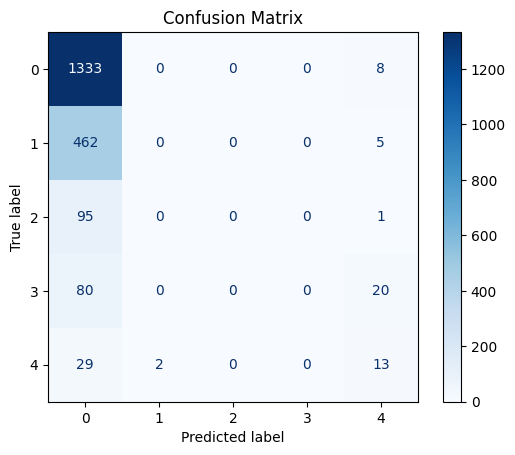

Test Loss: 0.9589, Test Accuracy: 0.6572


In [9]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def test_model(model, test_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.float().to(device), labels.to(device)
            images = images.permute(0, 3, 1, 2)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Store labels and predictions for confusion matrix
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    
    # Calculate and display confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Confusion Matrix")
    plt.show()

    test_loss = running_loss / len(test_loader)
    test_accuracy = correct / total
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Load the best model weights
model.load_state_dict(torch.load(save_path))

# Create the test DataLoader
test_dataset = MammographyDataset(test_label, main_img_dir, transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Test the model and display the confusion matrix
test_model(model, test_loader, criterion)
